In [1]:
import os

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from joblib import dump

This notebook is converting every numpy array to a pandas dataframe before training and predicting to avoid the following warnings:

UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names

In [9]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [3]:
scaler = MinMaxScaler()
scaler.fit(train_data)
norm_values = scaler.transform(train_data)

In [4]:
lgb_model = lgb.LGBMRegressor(objective="regression", n_estimators=50, max_depth=5, learning_rate=0.01, n_jobs=4)
bst = MultiOutputRegressor(lgb_model)
bst.fit(pd.DataFrame(norm_values), pd.DataFrame(norm_values))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 1202, number of used features: 17
[LightGBM] [Info] Start training from score 0.670413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.01, max_depth=5,
                                             n_estimators=50, n_jobs=4,
                                             objective='regression'))

In [5]:
reconstructed = bst.predict(pd.DataFrame(norm_values))
reconstructed

array([[0.78946192, 0.74498345, 0.60510412, ..., 0.        , 0.        ,
        0.        ],
       [0.71037921, 0.6699786 , 0.56804129, ..., 0.        , 0.        ,
        0.        ],
       [0.77933561, 0.72791621, 0.64752765, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.49027694, 0.4417909 , 0.34130872, ..., 0.        , 0.        ,
        0.        ],
       [0.49027694, 0.4417909 , 0.34130872, ..., 0.        , 0.        ,
        0.        ],
       [0.49027694, 0.4417909 , 0.34130872, ..., 0.        , 0.        ,
        0.        ]])

In [6]:
mse = np.mean((norm_values - reconstructed)**2, axis=1)
mse

array([0.00442936, 0.01022697, 0.0055192 , ..., 0.0220857 , 0.0220857 ,
       0.0220857 ])

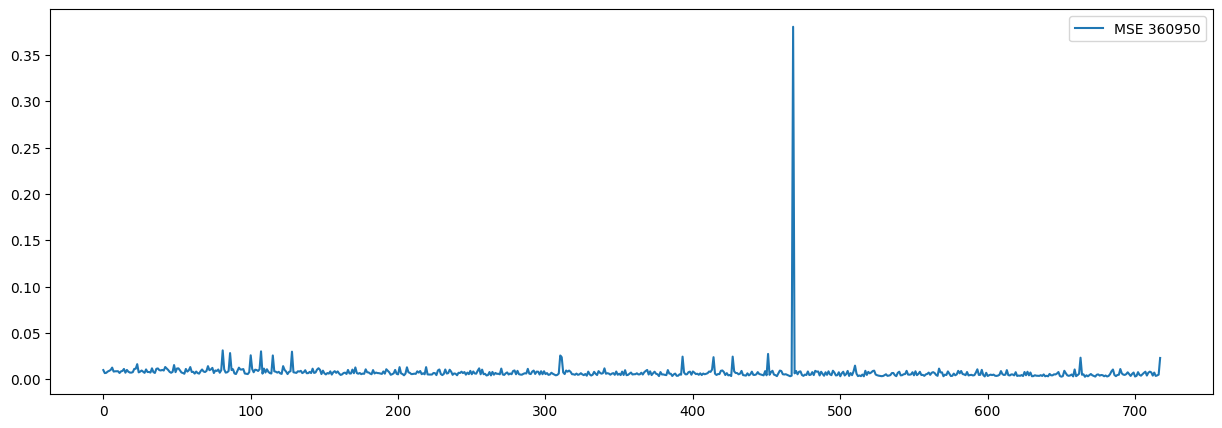

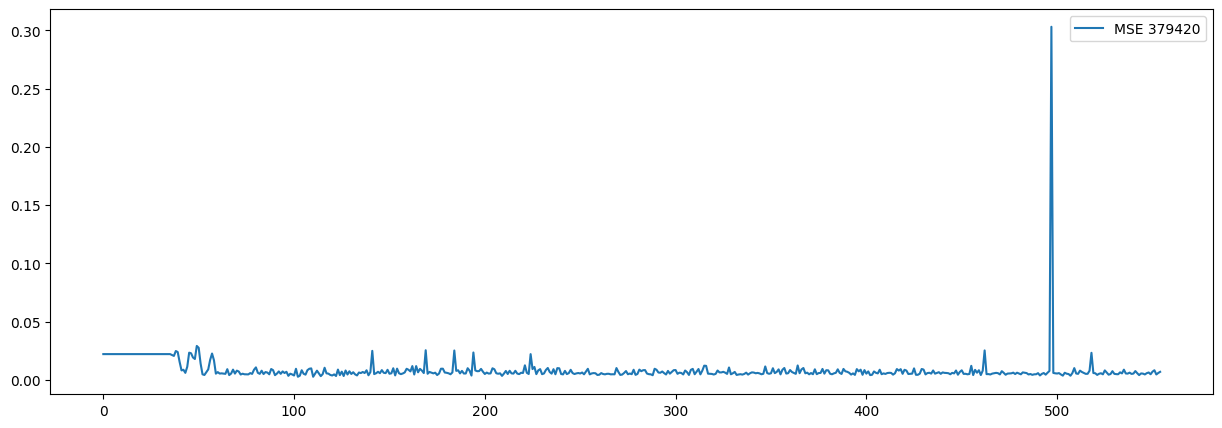

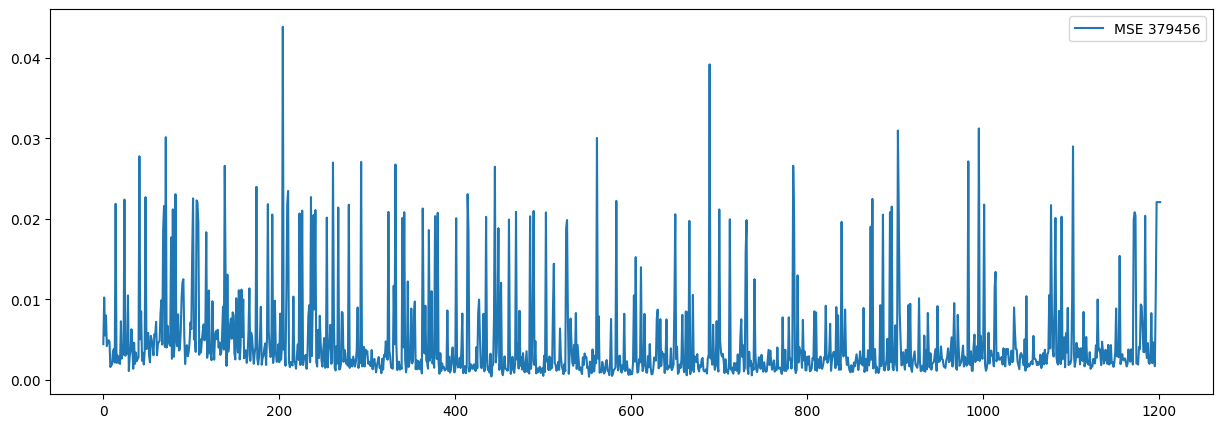

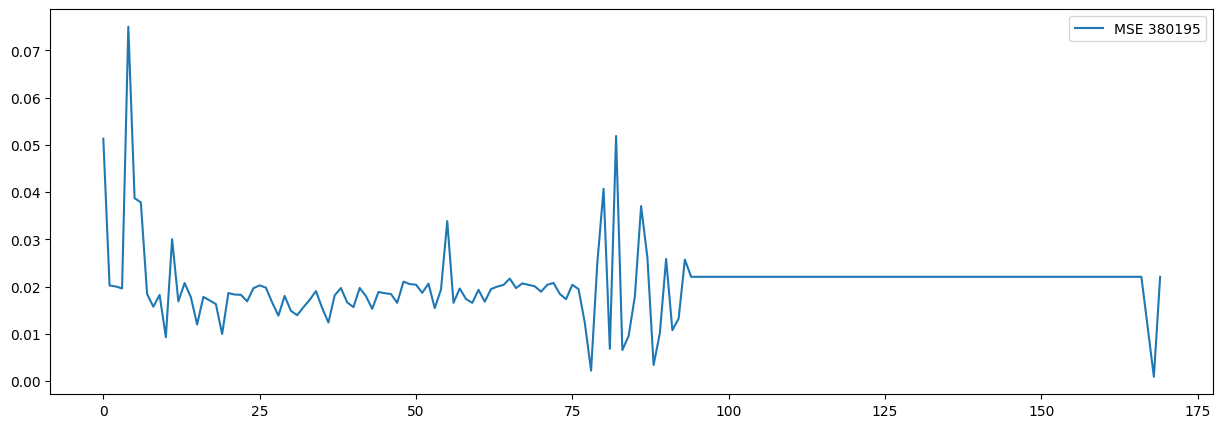

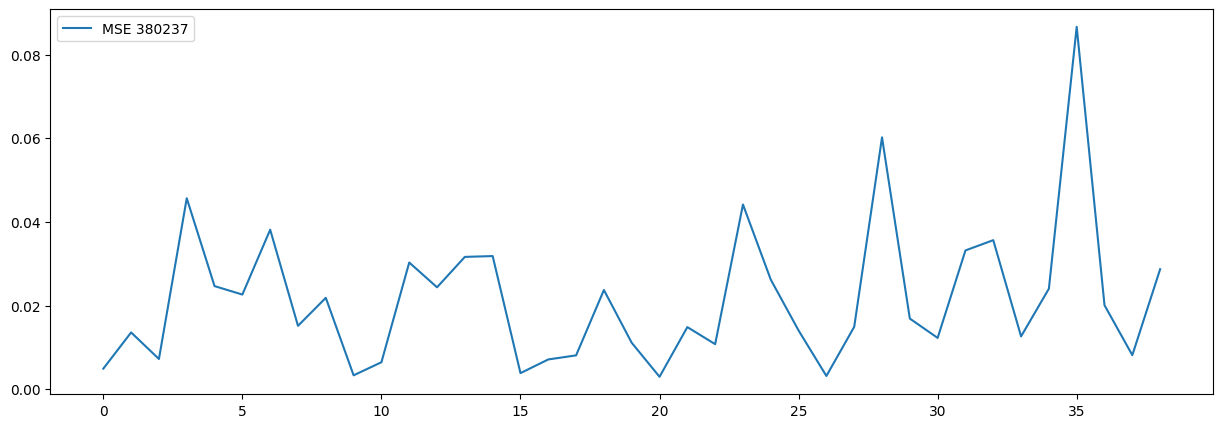

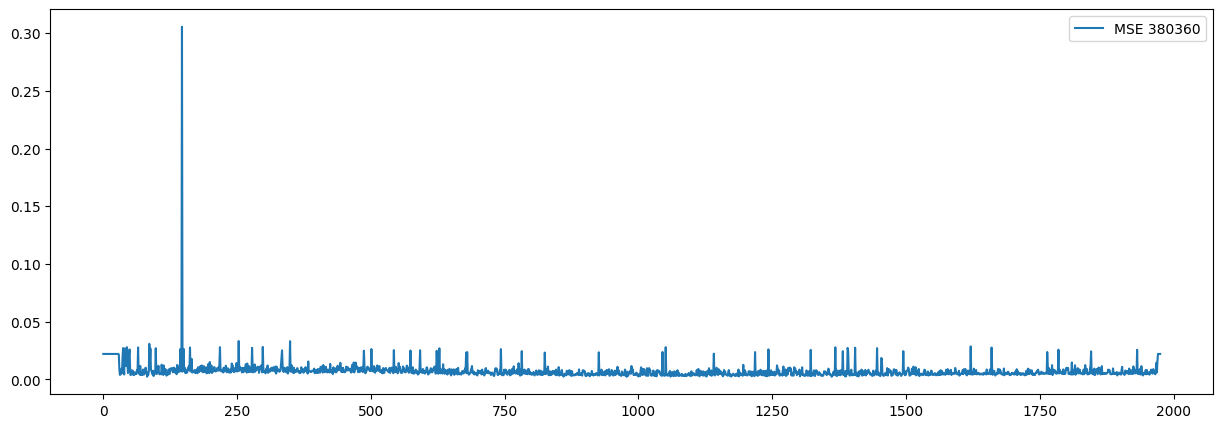

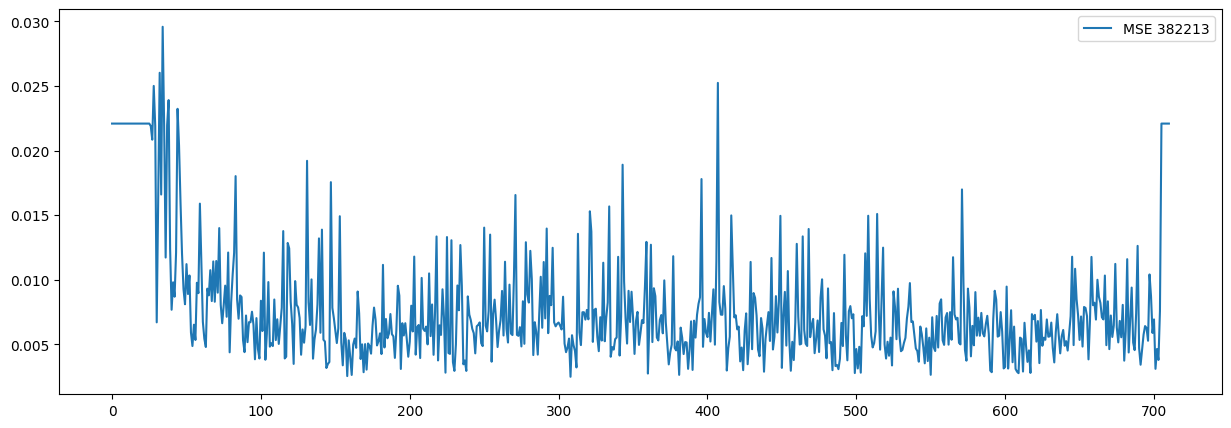

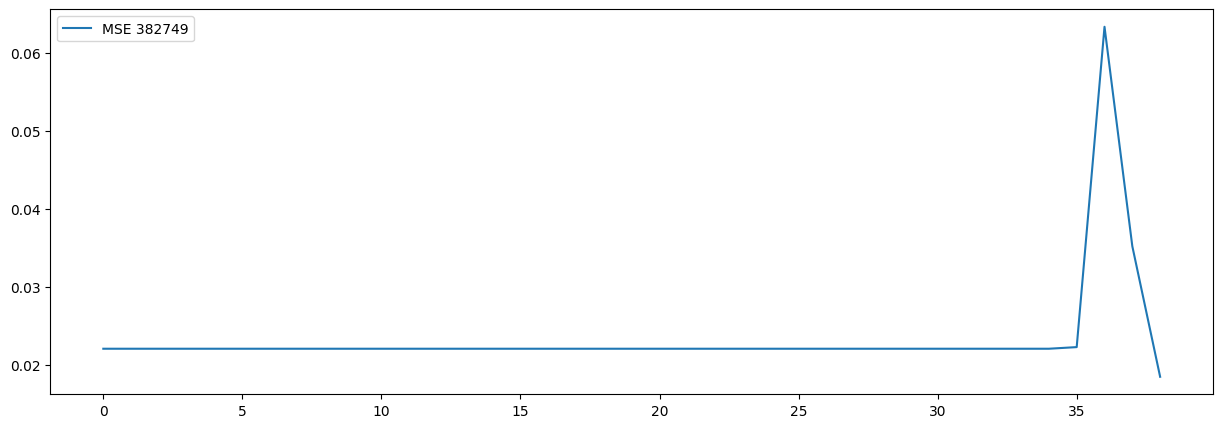

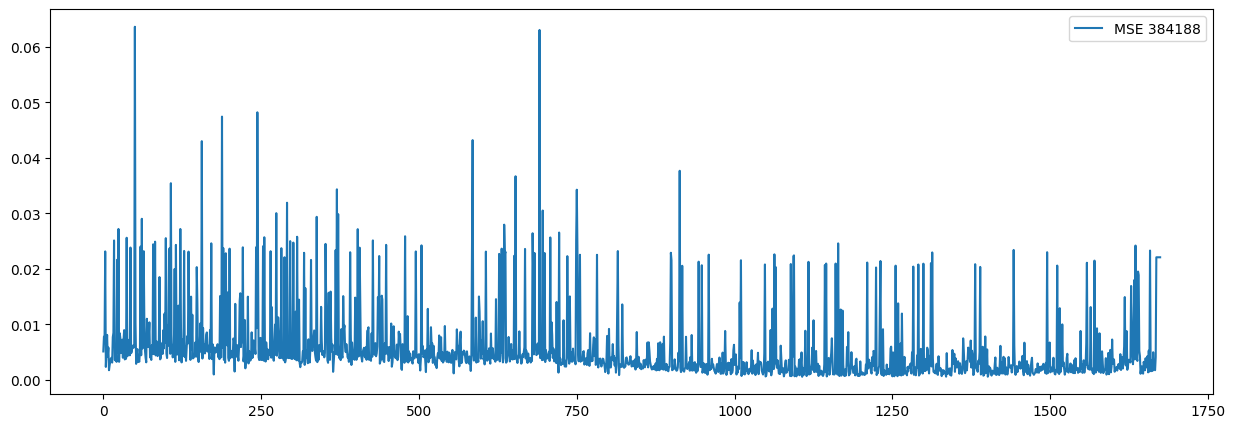

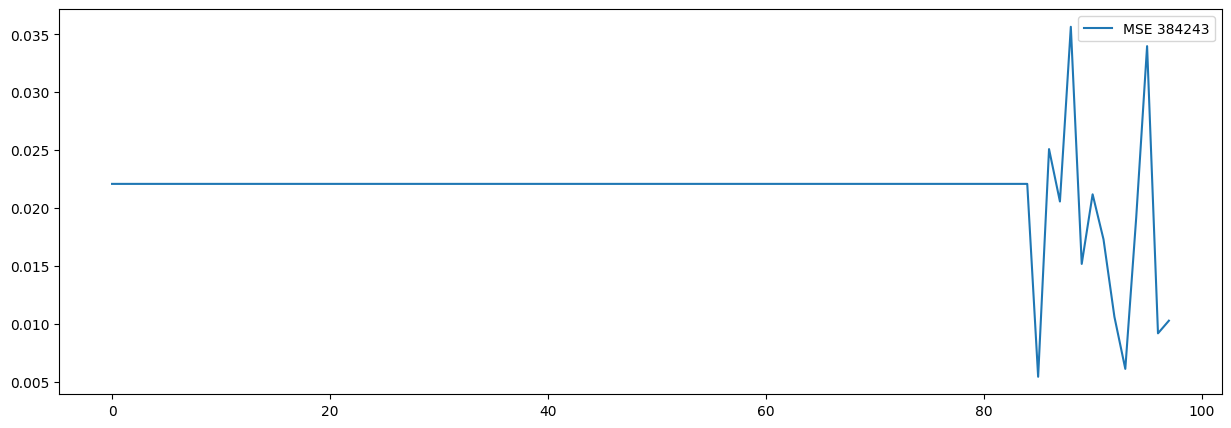

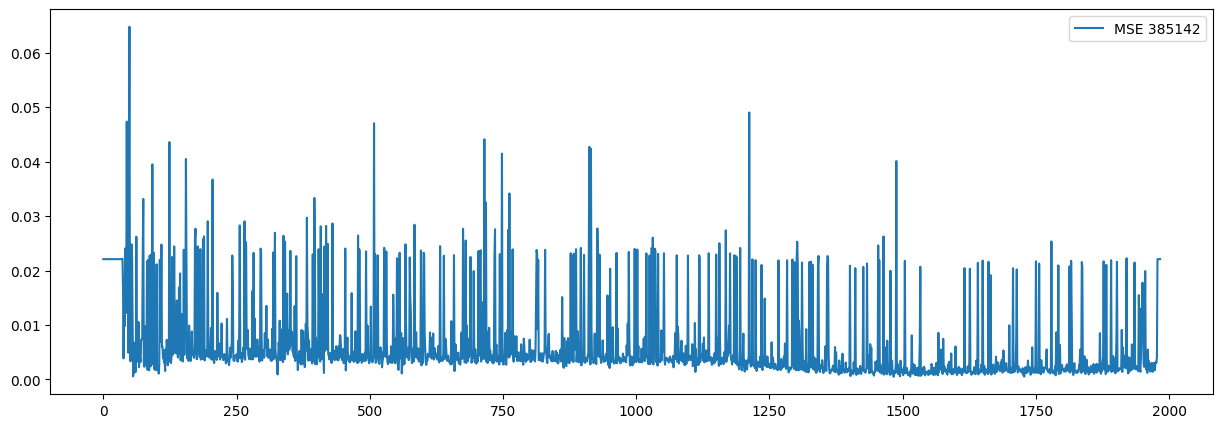

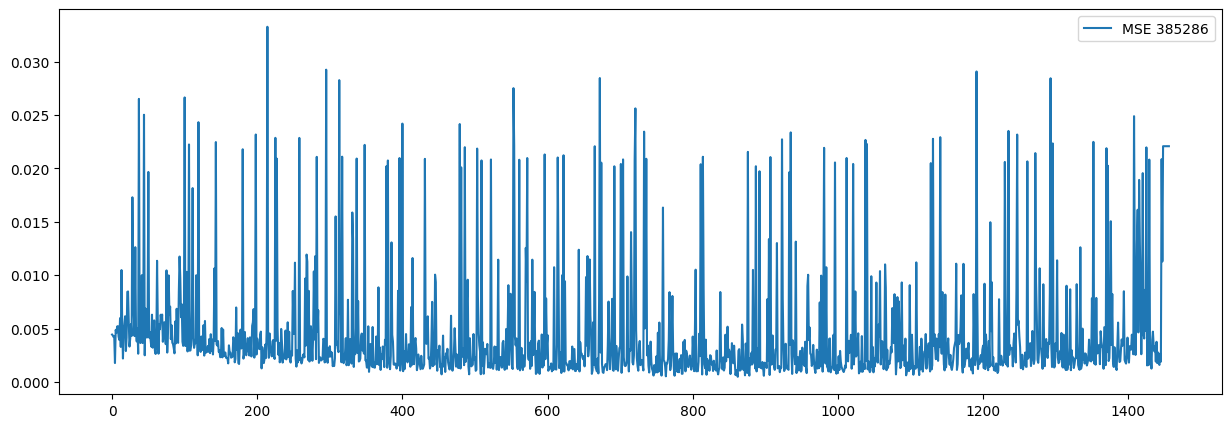

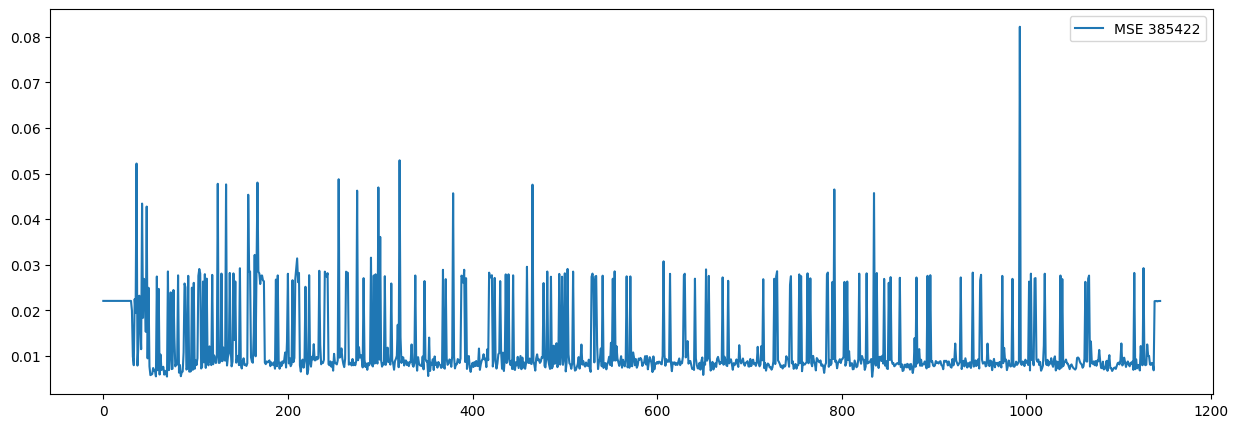

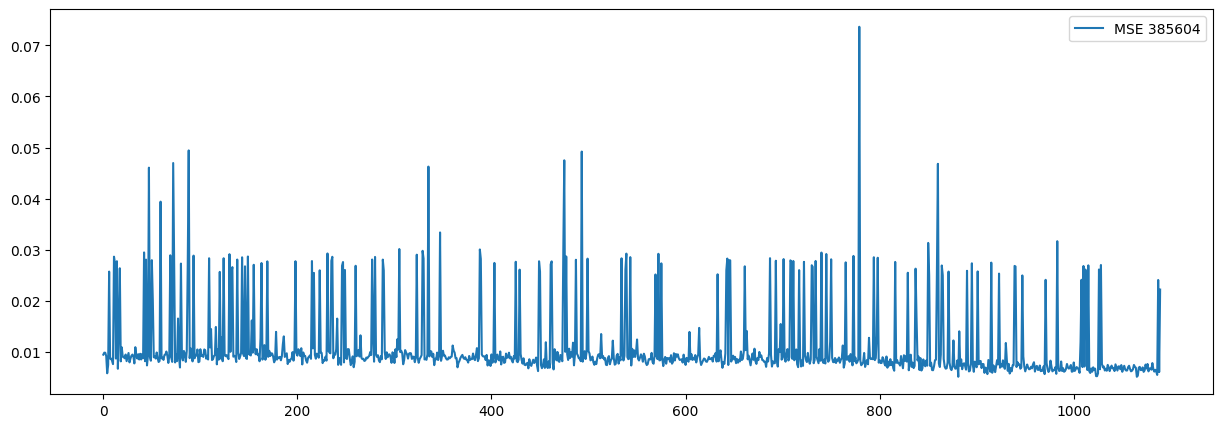

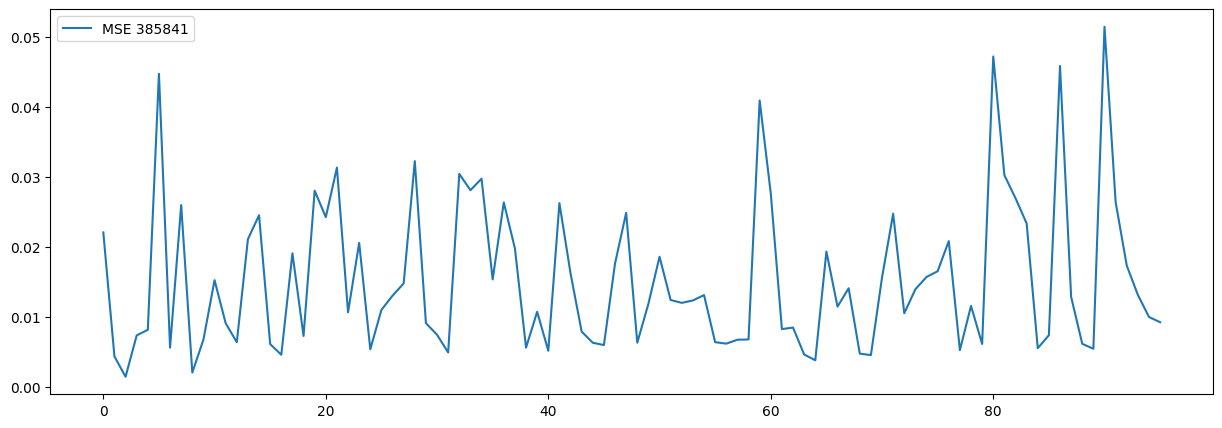

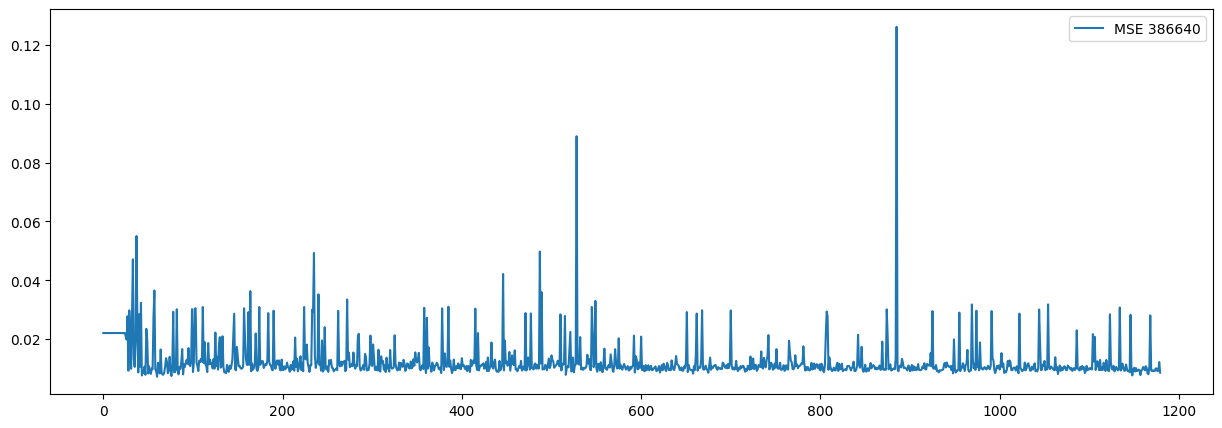

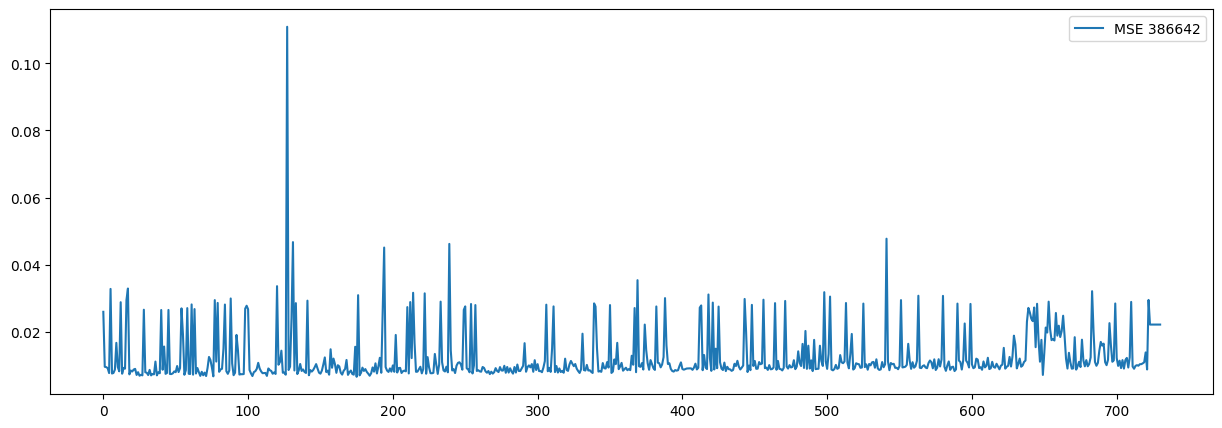

In [7]:
for run_number in np.unique(run_arr):
    test_data = data_arr[run_arr == run_number]

    scaler = MinMaxScaler()
    scaler.fit(test_data)
    test_data = scaler.transform(test_data)

    reconstructed = bst.predict(pd.DataFrame(test_data))
    mse = np.mean((test_data - reconstructed)**2, axis=1)

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [8]:
os.makedirs("../models/lightgbm_regressor", exist_ok=True)
dump(bst, '../models/lightgbm_regressor/model.joblib')

['../models/lightgbm_regressor/model.joblib']